# Quality control reporting

## Import libraries

In [1]:
# Load necessary packages
suppressPackageStartupMessages({
    library(arrow)
    library(ggplot2)
    library(dplyr)
    library(tidyr)
})

Warning message:
“package ‘arrow’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”


## Load in the QC results 

In [2]:
# Load the dataframe from a path
qc_results_df <- read_parquet("../qc_results/all_plates_qc_results.parquet")

# Check for any NaNs in the columns starting with Metadata_
metadata_cols <- grep("^Metadata_", colnames(qc_results_df), value = TRUE)
na_counts <- sapply(qc_results_df[metadata_cols], function(x) sum(is.na(x)))

# Print the count of NaNs for each Metadata_ column
na_counts

# Look at the dimensions and head of the dataframe
dim(qc_results_df)
head(qc_results_df)

Metadata_Plate   Metadata_Well   Metadata_Site Metadata_Zslice 
              0               0               0               0

[1] 9938   14

Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Zslice,Blurry_DNA,Blurry_Mito,Blurry_AGP,Blurry_Brightfield,Blurry_ER,Saturated_DNA,Saturated_Mito,Saturated_AGP,Saturated_Brightfield,Saturated_ER
<chr>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
NF0018,C10,1,ZS000,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
NF0018,C10,1,ZS001,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
NF0018,C10,1,ZS002,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
NF0018,C10,1,ZS003,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
NF0018,C10,1,ZS004,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
NF0018,C10,1,ZS005,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


## Melt dataframe to reduce columns

In [3]:
condition_cols <- grep("Blurry|Saturated", colnames(qc_results_df), value = TRUE)

# Assuming qc_results_df is your dataframe and condition_cols is a vector of column names
melted_qc_df <- qc_results_df %>%
  pivot_longer(
    cols = all_of(condition_cols),
    names_to = c("Condition", "Channel"),
    names_sep = "_",
    values_to = "Failed"
  )

dim(melted_qc_df)
head(melted_qc_df)

[1] 99380     7

Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Zslice,Condition,Channel,Failed
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<lgl>
NF0018,C10,1,ZS000,Blurry,DNA,FALSE
NF0018,C10,1,ZS000,Blurry,Mito,FALSE
NF0018,C10,1,ZS000,Blurry,AGP,FALSE
NF0018,C10,1,ZS000,Blurry,Brightfield,FALSE
NF0018,C10,1,ZS000,Blurry,ER,FALSE
NF0018,C10,1,ZS000,Saturated,DNA,FALSE


## Generate count per condition and channel

In [4]:
# Extract the condition and channel information from the column names
conditions_channels <- data.frame(
    Condition = sub("_(.*)", "", condition_cols),
    Channel = sub("^(Blurry|Saturated)_(.*)", "\\2", condition_cols),
    Column = condition_cols
)

# Calculate the counts of failed z-slices for each condition and channel
failed_counts <- conditions_channels %>%
    rowwise() %>%
    mutate(
        # Construct the column name by combining Condition and Channel
        Column = paste(Condition, Channel, sep = "_"),
        
        # Sum the counts of failed z-slices in the constructed column
        Count = sum(qc_results_df[[Column]] > 0, na.rm = TRUE)
    ) %>%
    select(-Column) %>%
    ungroup()

# Show dimension and head of failed counts dataframe
dim(failed_counts)
head(failed_counts)

[1] 10  3

Condition,Channel,Count
<chr>,<chr>,<int>
Blurry,DNA,3
Blurry,Mito,10
Blurry,AGP,36
Blurry,Brightfield,76
Blurry,ER,22
Saturated,DNA,30


## Plot the count of failed z-slices across channel and condition

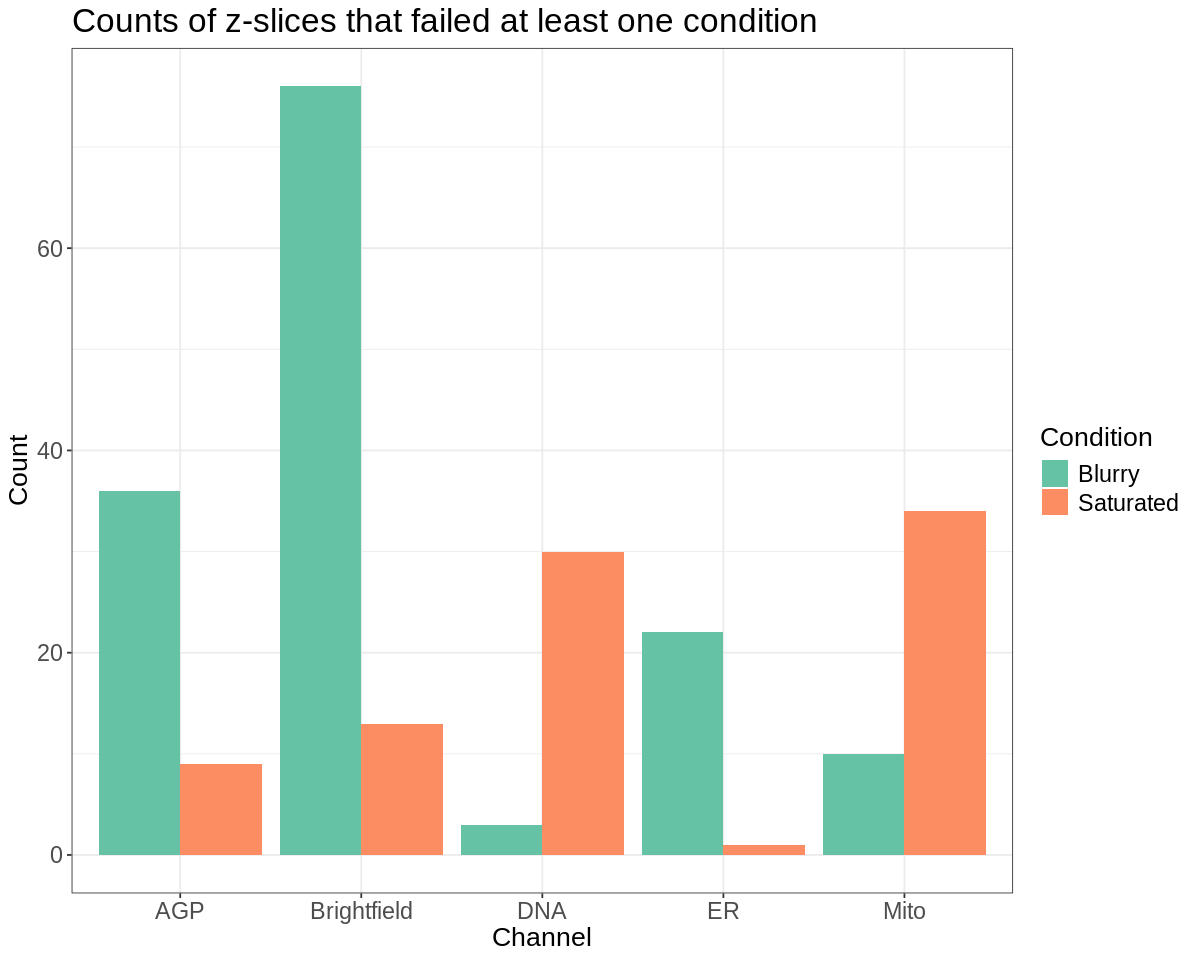

In [5]:
# Set width and height
width = 10
height = 8
options(repr.plot.width = width, repr.plot.height = height)

# Plot the bar chart of counts of failed z-slices for each condition and channel
count_zslices_channel <- ggplot(failed_counts, aes(x = Channel, y = Count, fill = Condition)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_brewer(palette = "Set2") +
    labs(
        title = "Counts of z-slices that failed at least one condition",
        x = "Channel",
        y = "Count"
    ) +
    theme_bw() +
    theme(
        plot.title = element_text(size = 20),
        axis.title = element_text(size = 16),
        axis.text = element_text(size = 14),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14)
    )

# Show plot
print(count_zslices_channel)

# Save plot
ggsave("count_zslices_channel.png", plot = count_zslices_channel, width = width, height = height, dpi = 500)


## Calculate number of z-slices failed per slice

In [6]:
# Group by Metadata_Zslice, Condition, and Channel, then summarize the number of failed zslices
failed_zslices_per_metadata <- melted_qc_df %>%
    group_by(Metadata_Zslice, Condition, Channel) %>%
    summarize(Failed_Count = sum(Failed == TRUE, na.rm = TRUE)) %>%  # Explicitly count TRUE values
    ungroup()

# Show dimension and head of the resulting dataframe
dim(failed_zslices_per_metadata)
head(failed_zslices_per_metadata)

`summarise()` has grouped output by 'Metadata_Zslice', 'Condition'. You can
override using the `.groups` argument.


[1] 650   4

Metadata_Zslice,Condition,Channel,Failed_Count
<chr>,<chr>,<chr>,<int>
ZS000,Blurry,AGP,2
ZS000,Blurry,Brightfield,2
ZS000,Blurry,DNA,0
ZS000,Blurry,ER,1
ZS000,Blurry,Mito,1
ZS000,Saturated,AGP,0


## Plot the failed counts across each z-slice

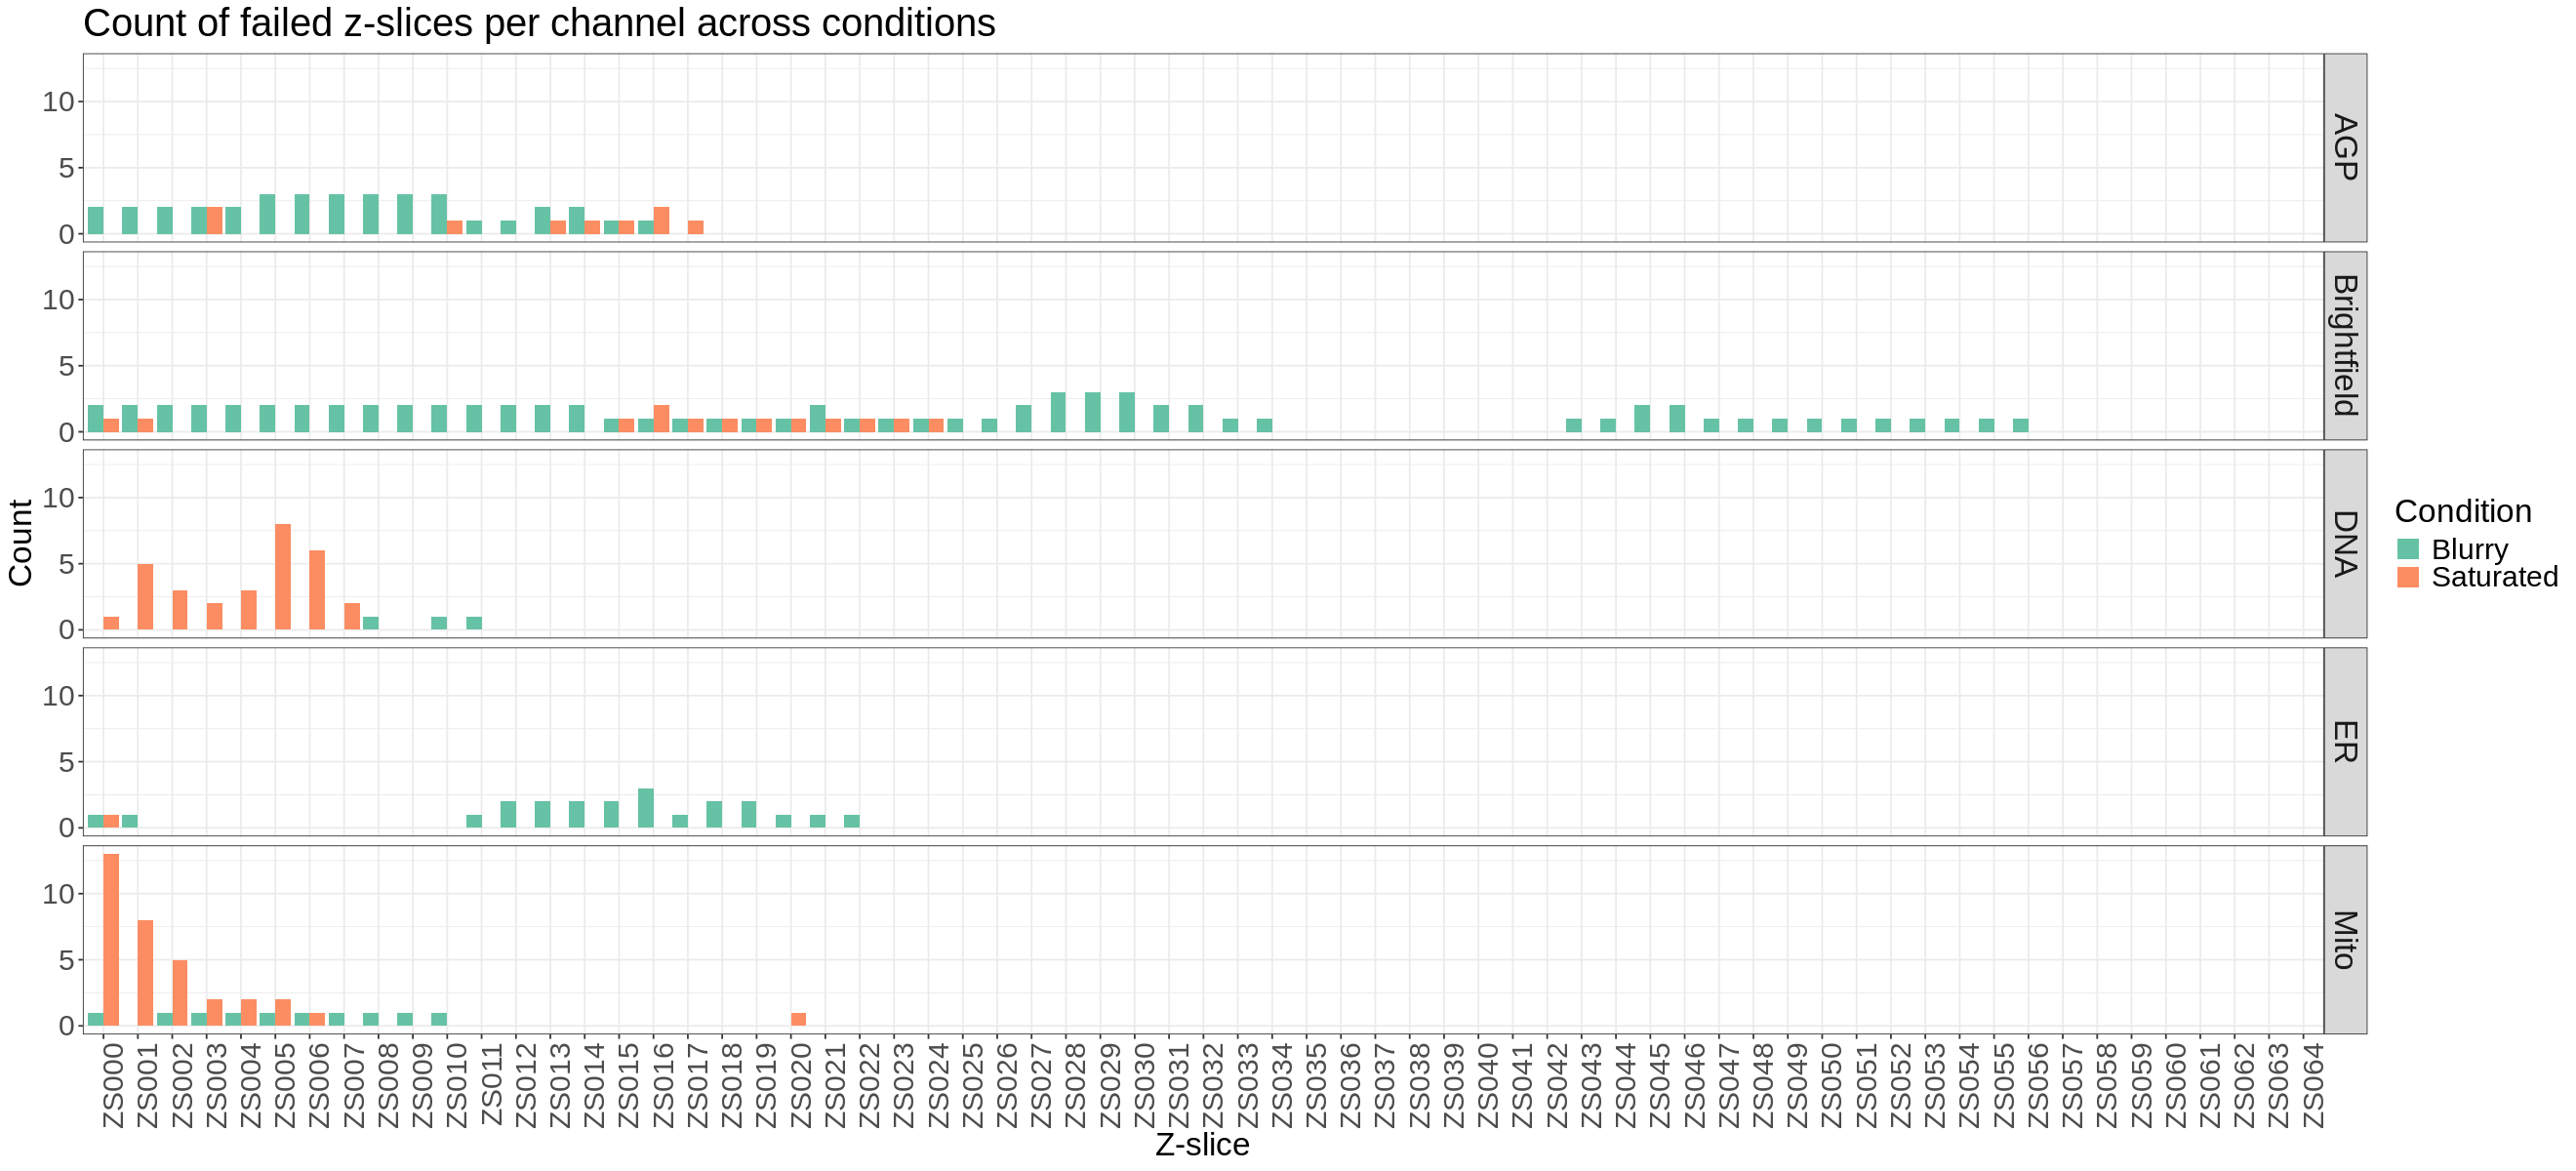

In [7]:
# Calculate the maximum Failed_Count across the entire dataset
max_failed_count <- max(failed_zslices_per_metadata$Failed_Count, na.rm = TRUE)

# Set width and height
width = 22
height = 10
options(repr.plot.width = width, repr.plot.height = height)

# Create the bar plot with consistent y-axis limits and red dotted line at Failed_Count = 1
bar_plot <- ggplot(failed_zslices_per_metadata, aes(x = Metadata_Zslice, y = Failed_Count, fill = Condition)) +
    geom_bar(stat = "identity", position = "dodge", linewidth = 2) +
    facet_grid(Channel ~ .) +
    scale_fill_brewer(palette = "Set2") +
    labs(
        title = "Count of failed z-slices per channel across conditions",
        x = "Z-slice",
        y = "Count"
    ) +
    theme_bw() +
    theme(
        plot.title = element_text(size = 24),
        axis.title = element_text(size = 20),
        axis.text.y = element_text(size = 18),
        axis.text.x = element_text(size = 18, angle = 90, hjust = 1),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 18),
        strip.text = element_text(size = 20)
    ) +
    ylim(0, max_failed_count)
    
# Show plot
print(bar_plot)

# Save plot
ggsave("failed_zslice_count_channel_and_condition.png", plot = bar_plot, width = width, height = height, dpi = 500)

## Determine number of failed organoids based on failed z-slices

In [8]:
# Filter the dataframe for rows where any of the condition columns are TRUE
failed_zslices_df <- qc_results_df[apply(qc_results_df[condition_cols], 1, any), ]

# Count the unique combinations of Metadata_Plate, Metadata_Well, and Metadata_Site
unique_failed_organoids <- failed_zslices_df %>%
  select(Metadata_Plate, Metadata_Well, Metadata_Site) %>%
  distinct()

# Print the number of unique failed organoids
total_unique_organoids <- nrow(unique_failed_organoids)
cat("Total unique organoids that would fail:", total_unique_organoids, "\n")

# Calculate and print the percentage of unique failed organoids out of the total
total_organoids <- qc_results_df %>%
  select(Metadata_Plate, Metadata_Well, Metadata_Site) %>%
  distinct() %>%
  nrow()

percentage_failed <- (total_unique_organoids / total_organoids) * 100
cat("Percentage of unique organoids that would fail:", round(percentage_failed, 2), "%\n")

Total unique organoids that would fail: 56 
Percentage of unique organoids that would fail: 14.55 %


In [9]:
# Filter the dataframe for rows where any of the condition columns are TRUE
failed_zslices_df <- qc_results_df[apply(qc_results_df[condition_cols], 1, any), ]

# Count the number of failing z-slices per organoid
failed_zslices_per_organoid <- failed_zslices_df %>%
  group_by(Metadata_Plate, Metadata_Well, Metadata_Site) %>%
  summarise(failed_zslices_count = n(), .groups = "drop")

# Organize organoids by the number of failing z-slices
failed_more_than_1 <- failed_zslices_per_organoid %>%
  filter(failed_zslices_count > 1)

failed_1 <- failed_zslices_per_organoid %>%
  filter(failed_zslices_count == 1)

# Print the number of organoids that have more than 1 failing z-slices
cat("Number of organoids with more than 1 failing z-slices:", nrow(failed_more_than_1), "\n")

# Print the number of organoids that have 1 failing z-slices
cat("Number of organoids with 1 failing z-slices:", nrow(failed_1), "\n")

Number of organoids with more than 1 failing z-slices: 37 
Number of organoids with 1 failing z-slices: 19 
